In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

## Logistic Regression

### model

基本思想：Y值只能取0或1，因此将线性模型套一层sigmoid函数，作为**Y=0的概率**
$$ P(Y = 0 | X) = sigmoid(wx) $$

sigmoid函数的取值：**logistic distribution** CDF
$$ F(x) = \frac{1}{1 + e^{-x}} $$

Text(-3, 0.8, '$F(x) = \\frac{1}{1 + e^{-x}}$')

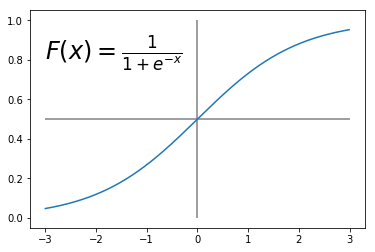

In [2]:
x = np.array([x / 100 for x in range(-300, 300)])
y = 1 / (1 + np.exp(-x))

plt.vlines(0, 0, 1, color='grey')
plt.hlines(0.5, -3, 3, color='grey')
plt.plot(x, y)
plt.text(-3, 0.8, r'$F(x) = \frac{1}{1 + e^{-x}}$', fontsize=24)

为什么sigmoid函数要取这个？因为这样取，模型就有了数学意义：Y=1的**对数几率(log odds)**为x的线性函数，即里面的$wx$

> for *probit model*, sigmoid function is N(0,1) CDF

**几率(odds)** 指的是一件事发生和不发生的概率比值，对数几率(log odds)就是在外面套一层对数函数

$$ \text{log-odds} = \log(\frac{p}{1-p}) $$ 

Y=0和1的概率可以表示为：
$$ P(Y = 0) = F(wx) = \frac{e^{wx}}{1 + e^{wx}}$$
$$ P(Y = 1) = 1 - F(wx) = \frac{1}{1 + e^{wx}}$$

两式相除得到 Y = 1 的对数几率： $ wx $

### 模型参数w的估计：极大似然估计 

经过一番不太复杂的推导，对数似然函数为：

$$ \sum_{i=1}^{N} y_i(wx_i) - \log(1 + e^{wx_i}))  \quad y_i \in {0, 1} $$

下面画图来理解这个函数

Text(0.5, 1.0, 'incorrect prediction')

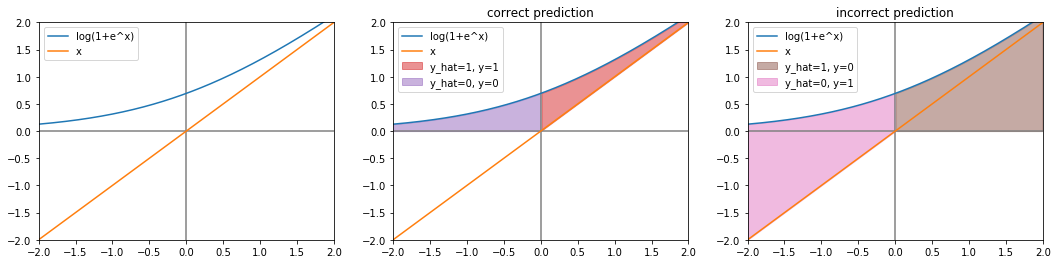

In [3]:
x = np.array([x / 100 for x in range(-200, 200)])
y = np.log(1 + np.exp(x))

fig, axs = plt.subplots(1, 3, figsize=(18, 4))

for i in range(3):
    ax = axs[i]
    ax.plot(x, y, label='log(1+e^x)')
    ax.plot(x, x, label='x')
    ax.vlines(0.0, ymin=-100, ymax=100, colors='grey')
    ax.hlines(0.0, xmin=-100, xmax=100, colors='grey')
    ax.set_ylim((-2, 2))
    ax.set_xlim((-2, 2))
    ax.legend()

# 预测正确
axs[1].fill_between(x[x > 0], x[x > 0], y[x > 0], color='C3', alpha=0.5, label='y_hat=1, y=1')
axs[1].fill_between(x[x < 0], 0, y[x < 0], color='C4', alpha=0.5, label='y_hat=0, y=0')
axs[1].legend()
axs[1].set_title('correct prediction')

# 预测错误
axs[2].fill_between(x[x > 0], 0, y[x > 0], color='C5', alpha=0.5, label='y_hat=1, y=0')
axs[2].fill_between(x[x < 0], x[x < 0], y[x < 0], color='C6', alpha=0.5, label='y_hat=0, y=1')
axs[2].legend()
axs[2].set_title('incorrect prediction')

最大化对数似然函数 ==> 最小化图中的面积

- 0附近的预测比较“重要”：
    + 预测错误，penalty较小
    + 预测正确，对L的“加成”较多
- 越是偏离0附近（即确定性较大、“理应”预测对的）的预测错误的“惩罚”越大、预测正确的“奖励”越小

### 求解数值方法：牛顿法

#### 原理

无约束最优化问题的通用解法。目标函数为 $$ \min_{x} f(x) $$

假设目前处于点$x^{k}$，寻找下一个点$x^{k+1}$，使得它为极小值点。

在$x^k$附近泰勒一阶展开梯度函数$f^\prime(x)$，有

$$ f^\prime(x^{k+1}) - f^\prime(x^k)= f^{\prime\prime}(x^k)(x^{k+1} - x^k) $$

而极小值点的必要条件为一阶导数（梯度）等于0，即式中第一项 $f^\prime(x^{k+1}) = 0$，由此得到每次迭代的公式

$$ x^{k+1} = x^k - H^{-1}(x^k) g(x^k)$$

我们需要根据 $f(\cdot)$ 的具体形式，纸笔推导出 $g(\cdot)$ 和 $H(\cdot)$ 的具体形式，再编程实现求解过程

#### 在Logistic回归中的应用

目标函数 $f$ 为对数似然函数（因为是最小化，加一个负号），优化自变量为模型中的 $w$

$$ f(w) = - \sum_i (y_i x_i - log(1 + e^{w x_i})$$

纸笔推导出梯度函数和海塞矩阵函数为

$$ g(w) = - \sum_i (y_i - P1(w, x_i)) x_i $$
$$ H(w) = \sum_i x_i^T x_i  P1(w, x_i)  P0(w, x_i)$$

where

$$ P1 = Prob(Y=1) = \frac{e^{wx}}{1 + e^{wx}} \quad\quad  (scalar) $$
$$ P0 = Prob(Y=0) = \frac{1}{1 + e^{wx}} \quad\quad  (scalar) $$

In [4]:
class Logistic(object):
    """Logistic model"""
    
    def __init(self):
        self.data = None
        
    def fit(self, df, y_column='y'):
        self.data = df
        self.features = df.drop(y_column, axis=1).columns.values
        self.X = df[self.features].values
        self.n, self.m = self.X.shape
        self.y = df[y_column].values.reshape(self.n, 1)
        
        self._P0, self._P1 = Logistic.PFactory(self.X)
        self._loglikelyhood_f = Logistic.LoglikelyhoodFunctionFactory(self.X, self.y)
        self._gradient_g = Logistic.GradientFunctionFactory(self.X, self.y)
        self._hesse_h = Logistic.HessematrixFunctionFactory(self.X)
        
        start = np.repeat(0.0, self.m).reshape(self.m, 1)
        opt = NewtonMethod(f=self._loglikelyhood_f, g=self._gradient_g, h=self._hesse_h, start=start, precision=0.000001)
        opt.run()
        
        self.opt = opt
        self.fitted_w = opt.result_x
        self.loglikelyhood_function_value = opt.result_y
        # self.print_summary()
        
    def print_summary(self):
        txt = """================== Logistic Regression Result ========================
        w = {}.T
        L(w) = {}
        iteration times: {}
        """.format(self.fitted_w.T, self.loglikelyhood_function_value, self.opt.n_iter)
        print(txt)
        
    @staticmethod
    def LoglikelyhoodFunctionFactory(X, y):
        def f(w):
            return - np.sum(y * X.dot(w) - np.log(1 + np.exp(X.dot(w))))
        return f
    
    @staticmethod
    def GradientFunctionFactory(X, y):
        def g(w):
            _, P1 = Logistic.PFactory(X)
            return - X.T.dot(y - P1(w))
        return g
    
    @staticmethod
    def HessematrixFunctionFactory(X):
        def h(w):
            P1, P0 = Logistic.PFactory(X)
            return (P1(w) * P0(w) * X).T.dot(X)
        return h
    
    @staticmethod
    def PFactory(X):
        
        def P0(w):
            return 1 / (1 + np.exp(X.dot(w)))
        
        def P1(w):
            return 1 - P0(w)
        
        return P0, P1
    
            
class NewtonMethod(object):
    """牛顿法"""
    
    def __init__(self, f, g, h, start, precision=0.01, max_iter=np.inf):
        self.f = f
        self.g = g
        self.h = h
        self.start_x = start
        self.precision = precision  # 当 || g_k || < precision, 停止 
        self.max_iter = max_iter    # 最大迭代次数
        
        # results
        self.x_value = []
        self.f_value = []
        self.g_value = []
        self.h_value = []
        self.n_iter = 0
        self.result_x = None
        self.result_y = None
        
    def run(self):
        x = self.start_x
        n_iter = 0
        
        while True:
            fx = self.f(x)
            gx = self.g(x)
            hx = self.h(x)
            self.x_value.append(x)
            self.f_value.append(fx)
            self.g_value.append(gx)
            self.h_value.append(hx)
            
            if np.sqrt(np.sum(gx ** 2)) < self.precision:
                print('满足精度要求，停止迭代')
                break
            
            x = x - np.linalg.inv(hx).dot(gx)
            n_iter += 1
            
            if n_iter > self.max_iter:
                print('达到最大迭代次数，停止迭代')
                break

        self.result_x = x
        self.result_y = fx
        self.n_iter = n_iter
            
    def summary(self):
        print('iteration times: {}\nx = {}\nf(x) = {}'.format(self.n_iter, self.result_x, self.result_y))

In [5]:
import numpy as np

w = np.array([[1], [10], [0]])
X = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
])
y = np.array([[1, 1, 1, 0, 0, 0]]).T

df = pd.DataFrame(X)
df['y'] = y

m = Logistic()
m.fit(df)
m.print_summary()

满足精度要求，停止迭代
================== Logistic Regression Result ========================
        w = [[-0.55501911  0.11248199  0.80705249]].T
        L(w) = 2.5514255043221032
        iteration times: 6
        


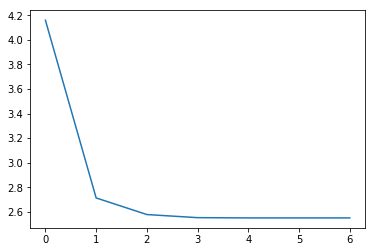

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(m.opt.f_value)

## Kaggle Home Credit Dataset

In [7]:
import pandas as pd
pd.options.display.max_columns = 130  # application_train.csv has 121 columns

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
raw_df = pd.read_csv('../data-homecredit/application_train.csv', nrows=1e3)

raw_df.sample(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
275,100318,0,Cash loans,F,N,N,0,90000.0,381528.0,12109.5,315000.0,Unaccompanied,Working,Higher education,Single / not married,House / apartment,0.018209,-9627,-189,-709.0,-2301,NaN,1,1,0,1,0,0,Core staff,1.0,3,3,WEDNESDAY,12,0,0,0,0,0,0,Trade: type 7,0.646881,0.533415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-141.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
755,100868,0,Cash loans,F,N,N,0,112500.0,450000.0,27324.0,450000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Separated,House / apartment,0.014520,-19129,-2919,-314.0,-2673,NaN,1,1,0,1,0,0,High skill tech staff,1.0,2,2,THURSDAY,14,0,0,0,0,0,0,Business Entity Type 3,NaN,0.608615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-2005.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
559,100645,0,Cash loans,M,Y,N,0,247500.0,900000.0,31887.0,900000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.019101,-12340,-3334,-4374.0,-4376,2.0,1,1,1,1,0,0,Managers,1.0,2,2,MONDAY,22,0,0,0,0,1,1,Transport: type 4,NaN,0.654196,0.450747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-390.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
710,100819,0,Cash loans,F,N,N,0,279000.0,1520253.0,44581.5,1327500.0,Unaccompanied,Pensioner,Secondary / 

## df

In [9]:
features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'CNT_CHILDREN'] #, 'NAME_EDUCATION_TYPE']
df = raw_df[features + ['TARGET']].copy()

df.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,CNT_CHILDREN,TARGET
0,202500.0,406597.5,0,1
1,270000.0,1293502.5,0,0
2,67500.0,135000.0,0,0
3,135000.0,312682.5,0,0
4,121500.0,513000.0,0,0


In [10]:
# numerical scaling
from sklearn.preprocessing import MinMaxScaler

for fe in ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'CNT_CHILDREN']:
    s = MinMaxScaler((0, 1))
    df[fe] = s.fit_transform(df[fe].astype(float).values.reshape(-1, 1))

df.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,CNT_CHILDREN,TARGET
0,0.233129,0.160227,0.0,1
1,0.325153,0.556478,0.0,0
2,0.049080,0.038883,0.0,0
3,0.141104,0.118268,0.0,0
4,0.122699,0.207766,0.0,0


In [11]:
m = Logistic()
m.fit(df, y_column='TARGET')
m.print_summary()

满足精度要求，停止迭代
================== Logistic Regression Result ========================
        w = [[-9.48295747 -3.05819171 -0.6753553 ]].T
        L(w) = 311.5620385048605
        iteration times: 6
        


In [12]:
# check my code with sklearn

from sklearn.linear_model import LogisticRegression


X = df.drop('TARGET', axis=1).values
y = df['TARGET'].values

mm = LogisticRegression(fit_intercept=False, C=100)
mm.fit(X, y)
mm.coef_

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[-9.35213565, -3.1138323 , -0.68719311]])

## Notes of sklearn LogisticRegression

- parameters: 
    + penalty must be in {'l1', 'l2'}. If we ned no penalty, set C to a very large number
    + C = 1 / lambda, aka. inverse of regularization strength
    + fit_intercept

## TODO

- more about Newton's method: solving equations, sqrt() etc.
- Gradient Descent